In [2]:
#importaciones necesarias:
import numpy as np
import os as os
from matplotlib import pyplot
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import applications
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras import optimizers

In [6]:
#leemos los datos de entrenamiento y validación:
longitud, altura = 224, 224
batch_size = 100

data_entrenamiento="melanoma/DermMel/train_sep"
data_validacion="melanoma/DermMel/valid"

entrenamiento_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

#definimos nuestros datasets de imágenes indicando el tamaño que van a tener las imágenes y el número de imágenes que se van
#a ir pasando a los modelos (batch_size).
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(data_entrenamiento,
    target_size=(altura, longitud),batch_size=batch_size,class_mode='categorical')

#lo mismo para las ímágenes de validación
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


In [7]:
#leemos el modelo indicando el tamaño de nuestras imágenes y la cantidad de clases que tendremos
base_model = tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),classes=2,weights='imagenet')
base_model.trainable= False #las capas del modelo se ponen a no entrenables
base_model.layers.pop()# eliminamos la última capa

In [19]:
#resumen del modelo donde se ve que ningún parámetro es entrenable por ahora
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
#creamos un nuevo modelo a partir del anterior y le añadimos una capa de global average pooling para resumir las salidas
#de la última capa
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

In [9]:
#añadimos una capa dense para ajustar la red a nuestro problema de clasificacón indicando que habrá dos clases y 
#que la función de activación es softmax
outputs = keras.layers.Dense(2,activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
#añadimos al modelo el optimtizar a a usar en el entrenamiento, su ratio de aprendizaje (lr) y que mediremos el accuracy
#para la optimización:
lr = 0.0004

model.compile(optimizer=optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
#entrenamos:
import numpy
epocas=30

steps_per_epoch = numpy.ceil(entrenamiento_generador.n / batch_size)
validation_steps = numpy.ceil(validacion_generador.n / batch_size)

history=model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=steps_per_epoch,
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
107/107 [==============================] - 602s 6s/step - loss: 0.6907 - accuracy: 0.5345 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 2/30
107/107 [==============================] - 597s 6s/step - loss: 0.6798 - accuracy: 0.5926 - val_loss: 0.6738 - val_accuracy: 0.7471
Epoch 3/30
107/107 [==============================] - 600s 6s/step - loss: 0.6712 - accuracy: 0.6302 - val_loss: 0.6652 - val_accuracy: 0.7485
Epoch 4/30
107/107 [==============================] - 604s 6s/step - loss: 0.6626 - accuracy: 0.6705 - val_loss: 0.6565 - val_accuracy: 0.7586
Epoch 5/30
107/107 [==============================] - 616s 6s/step - loss: 0.6552 - accuracy: 0.6793 - val_loss: 0.6489 - val_accuracy: 0.7574
Epoch 6/30
107/107 [==============================] - 604s 6s/step - loss: 0.6470 - accuracy: 0.7142 - val_loss: 0.6439 - val_accuracy: 0.6474
Epoch 7/30
107/107 [==============================] - 601s 6s/step

In [13]:
#guardamos el modelo generado y los pesos, para poder hacer luego el test:
model.save('./Experimentos/Nuevo dataset Net50/modelo_tf_resnet-exp1.h5')

In [14]:
model.save_weights('./Experimentos/Nuevo dataset Net50/pesos_tf_resnet-exp1.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


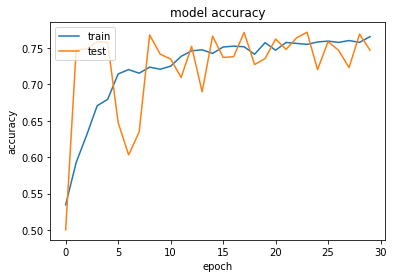

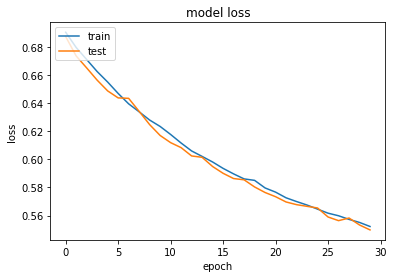

In [15]:
#realizamos una gráfica de la precisión y su error (loss) en cada época para validación y entrenamiento
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()